<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pressure-pert" data-toc-modified-id="Pressure-pert-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pressure pert</a></span></li><li><span><a href="#initial-velocities" data-toc-modified-id="initial-velocities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>initial velocities</a></span></li><li><span><a href="#non-z-lagrangian" data-toc-modified-id="non-z-lagrangian-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>non-z lagrangian</a></span></li><li><span><a href="#Scorer-parameter-correction" data-toc-modified-id="Scorer-parameter-correction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scorer parameter correction</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
from netCDF4 import Dataset
#import cmocean
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import cumtrapz
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px

In [ ]:
xenv = np.load('environparcels/x.npy')
yenv = np.load('environparcels/y.npy')
zenv = np.load('environparcels/z.npy')
uenv = np.load('environparcels/u.npy')
venv = np.load('environparcels/v.npy')
wenv = np.load('environparcels/w.npy')
thetaenv = np.load('environparcels/theta.npy')
presenv = np.load('environparcels/pres.npy')
rhoenv = np.load('environparcels/rho.npy')

speedenv = np.sqrt(uenv**2 + venv**2 + wenv**2)


# xjump = np.load('jumpparcels/xj.npy')
# yjump = np.load('jumpparcels/yj.npy')
# zjump = np.load('jumpparcels/zj.npy')
# ujump = np.load('jumpparcels/uj.npy')
# vjump = np.load('jumpparcels/vj.npy')
# wjump = np.load('jumpparcels/wj.npy')
# thetajump = np.load('jumpparcels/thetaj.npy')
# presjump = np.load('jumpparcels/presj.npy')
# rhojump = np.load('jumpparcels/rhoj.npy')


# speedjump = np.sqrt(ujump**2 + vjump**2 + wjump**2)

In [ ]:
# This cell here for comparison to previous handling, to be deleted after Paco and Morgan chat
df = px.data.gapminder()
template = 'plotly_white'

colmax = 110 # [m/s]
colmin = 0   # [m/s]
# colmax = 450 # [K]
# colmin = 330  # [K]
# colmax = 150 # [kPa]
# colmin = -100  # [kPa]
# colmax = 250 # [kPa]
# colmin = 0  # [kPa]
msize = 0.5

t1 = 2
t2 = 1800
skipt = 4

fig = go.Figure()

#env parcels
for ind in range(0,xenv.shape[1],1):
    if (ind > 3890) and (ind < 3910):
        scatvar = speedenv[t1:t2:skipt,ind]
#         scatvar = thetaenv[t1:t2:skipt,ind]
#         scatvar = presenv[t1:t2:skipt,ind].copy()
#         scatvar -= presenv[t1,ind] + rhoenv[t1:t2:skipt,ind] * 9.81 * (zenv[t1:t2:skipt,ind] - zenv[t1, ind])
#         scatvar /= 100
#         scatvar = presenv[t1:t2:skipt,ind] / 100
        fig.add_trace(go.Scatter3d(
            x=xenv[t1:t2:skipt,ind]/1000.+121,
            y=yenv[t1:t2:skipt,ind]/1000.+55,
            z=zenv[t1:t2:skipt,ind]/1000.,
            mode='markers',
            marker= dict(
                size=msize*2,
                color=scatvar,
                colorscale='Viridis',
                cmin=colmin,cmax=colmax,
    #             colorbar=dict(title='Potential temperature [K]',thickness=15)
#                 colorbar=dict(title='Pressure [hPa]',thickness=15)
                colorbar=dict(title='Windspeed [m/s]',thickness=15)
            ),
            projection=dict(x=dict(show=True,opacity=0.1),z=dict(show=True,opacity=0.1))
        ))
    


fig.update_layout(#title = '3D Scatter plot of parcels that reach windspeed>%.f m/s'%thresh,
    template=template,
    showlegend=False,
    width=950,height=700,
    scene=dict(camera=dict(up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=0.06,y=-2.3,z=0.51)),
        xaxis=dict(title='East [km]'),yaxis=dict(title='North [km]'),zaxis=dict(title='Altitude [km]'),
        aspectmode='data'))

# fig.write_html('jump_windspeed.html')
# fig.write_image("fig2A.pdf")
iplot(fig)



This class stores parcel path data (designed for 'environmental' parcels as defined in [2021 methodology](https://www.science.org/doi/10.1126/science.abh3857)) and facilitates slicing, plotting, and trasnformations for the comparsion to Smith (1985) discussed [here](https://purl.stanford.edu/mq326dq1556).

In [4]:
class SmithEstimator:    
    def __init__(
        self,
        x_env_data, # m
        y_env_data, # m
        z_env_data, # m
        u_env_data, # m/s
        v_env_data, # m/s
        w_env_data, # m/s
        theta_env_data, # K
        speed_env_data, # m/s
        pres_env_data, # Pa
        rho_env_data, # kg/m^3
    ):
        # restrict data to only parcels beginning within 1km of the median y initial value.
        # Also drops the first and last time-step because theta is zero everywhere for some reason
        flat_ind = self.__get_flat_y_ind(y_env_data[1:-1])
                        
        
        # All other manipulations in object instatiation taken from Morgan's code
        
        self.x_data = pd.DataFrame(
            x_env_data[1:-1, flat_ind] + 121000,
            index=pd.Index(range(1,len(x_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.y_data = pd.DataFrame(
            y_env_data[1:-1, flat_ind] + 55000,
            index=pd.Index(range(1,len(y_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )

        self.z_data = pd.DataFrame(
            z_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(z_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.u_data = pd.DataFrame(
            u_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(u_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.v_data = pd.DataFrame(
            v_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(v_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.w_data = pd.DataFrame(
            w_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(w_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.theta_data = pd.DataFrame(
            theta_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(theta_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.speed_data = pd.DataFrame(
            speed_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(speed_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.pres_data = pd.DataFrame(
            pres_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(pres_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        self.rho_data = pd.DataFrame(
            rho_env_data[1:-1, flat_ind],
            index=pd.Index(range(1,len(pres_env_data) - 1), name='time_step'),
            columns=pd.Index(flat_ind, name='parcel_idx')
        )
        
        # define datasets for all of the above restricted to only jump parcels, empty until 
        # populated by get_jump_parcels()
        self.x_data_jump = pd.DataFrame()
        self.y_data_jump = pd.DataFrame()
        self.z_data_jump = pd.DataFrame()
        self.u_data_jump = pd.DataFrame()
        self.v_data_jump = pd.DataFrame()
        self.w_data_jump = pd.DataFrame()
        self.theta_data_jump = pd.DataFrame()
        self.speed_data_jump = pd.DataFrame()
        self.pres_data_jump = pd.DataFrame()
        self.rho_data_jump = pd.DataFrame()
        self.jump_deflections = pd.DataFrame()
        
    @staticmethod
    def __get_flat_y_ind(y_data):
        """Helper function to isolate only the y-slice of data within 1km of the median"""
        median_y = np.median(y_data[0])
        to_be_included = np.abs(y_data[0] - median_y) <= 1000
        return np.array(range(len(y_data[0])))[to_be_included]
    
    def get_delta_z(parcel_ind):
        """Return the x and delta-z data for given parcel (specified using its index)"""
        parcel_x_data = self.x_data.loc[:,parcel_ind]
        delta_z = self.z_data.loc[:,parcel_ind] - self.z_data.loc[0,parcel_ind]
        return parcel_x_data, delta_z

    def get_h_and_displacement(self, hydraulic_jump_end_x=62):
        """
        Calculate obstacle height from lowest jump parcel and top streamline displacement from top jump parcel.
        Takes optional argument `hydraulic_jump_end_x` which specifies the x position of the bottom of the jump.
            Used for determining how far along the parcel path to continue when mapping data onto Smith diagram.
        """
        
        # begin by isolating only the jump parcels
        jump_parcels = self.get_jump_parcels()
        
        # extract the parcel index for the upper divinging streamline (d_parcel) and obstacle height (h_parcel)
        d_parcel = self.z_data[jump_parcels].iloc[0].idxmax()  
        h_parcel = self.z_data[jump_parcels].iloc[0].idxmin()

        
        last_x = self.__get_left_x_index(self.x_data[d_parcel], hydraulic_jump_end_x * 1000)
        
        # want to compare on equal x not t, so take the series of points (in t) of h_parcel that match the x values of the
        # the d_parcel x values
        matched_x_ind = self.match_parcels_by_x(self.x_data.loc[:last_x, d_parcel], self.x_data[h_parcel])
        d_xind = self.x_data.loc[:last_x, d_parcel][[i is not None for i in matched_x_ind]].index
        h_xind = [i for i in matched_x_ind if i is not None]
        
        # using x-aligned indices, take the delta-z data for both parcel paths
        d_zdata = self.z_data.loc[d_xind, d_parcel]
        delta_d = d_zdata - d_zdata.iloc[0]
        h_zdata = self.z_data.loc[h_xind,h_parcel]
        delta_h = h_zdata - h_zdata.iloc[0]

        g = 9.81 # [m/s^2]
        H = self.z_data[d_parcel].iloc[0] - self.z_data[h_parcel].iloc[0] # [m]
        
        # use average theta as the environmental theta
        theta_env = self.theta_data[jump_parcels].iloc[0].mean() # [K]
        
        # estimate theta gradient as difference in theta from top to bottom divided by H
        theta_gradient = (self.theta_data[d_parcel].iloc[0] - self.theta_data[h_parcel].iloc[0]) / H # [K/m]
        
        N = np.sqrt(g / theta_env * theta_gradient)
        
        # use average initial u as U_0
        u_0 = self.u_data[jump_parcels].iloc[0].mean() # [m/s]
        
        l = N / u_0
        print(f'scorer parameter: {l}')
        
        # calculate non-hydrostatic pressure perturbation --> then normalize according to equation 13 of paco's thesis
        p_perturbations = (self.__get_p_perturbation(d_parcel) 
                           / self.rho_data[d_parcel] / self.speed_data.loc[1, d_parcel]**2)[:last_x]
        
        d_normed = (delta_d * l)
        h_normed = (delta_h * l)
        h_normed.index = d_normed.index # match all indices to top dividing streamline
        
        # calculate 'cosine term' from equation 16 of paco's thesis
        cos_term = np.cos(H * l + d_normed - h_normed)
        
        plt.scatter(h_normed[::5], d_normed[::5], s=1)
        plt.axvline(0, color='k')
        plt.axhline(0, color='k')
        
        smith_solution_1_3994_X = [0, -0.04, -0.08, -0.11, -0.15, -0.19, -0.24, -0.28, -0.32, -0.36, 
                                   -0.40, -0.45, -0.49, -0.53, -0.57, -0.62, -0.66, -0.71, -0.75, -0.80, 
                                   -0.84, -0.89, -0.93, -0.98, -1.02, -1.07, -1.11, -1.16, -1.20, -1.25, 
                                   -1.30, -1.34, -1.39, -1.43, -1.48, -1.53, -1.57, -1.62, -1.67, -1.71, 
                                   -1.76]
        smith_solution_1_3994_Y = np.linspace(0, -2, 41)
        
        plt.plot(smith_solution_1_3994_X, smith_solution_1_3994_Y, color='r')
        
        plt.xlabel('obstacle height h', fontsize=15)
        plt.ylabel('dividing streamline deflection \u03B4')
        
        # can eiher display the 'n' number from Smith or normed H
#         plt.title(f'n(H_normed) = {((H * l) / (np.pi / 6))%12}')
        plt.title(f'H = {H * l}')
    
        plt.xlim([-2,None])
        plt.ylim([-2,None])
        
        return h_normed, d_normed, p_perturbations, cos_term, l, d_xind, d_parcel


    def get_jump_parcels(self, slope_bottom_x=61.5, slope_top_x=55):
        """
        extracts jump parcels, defined as those that decrease monotonically through hydraulic jump and and have u >> v
        optionally accepts `slope_top_x` and `slope_bottom_x`, which respectively define the furthest
            upstream and downstream x to use for the monotonicty condition
        """
        
        skips_jump_completely = 0
        v_condition = 0
        monotonicity_condition = 0
        jump_parcels = []
        for parcel in self.x_data.columns:
            parcel_data = self.x_data[parcel]
            slope_bottom = self.__get_left_x_index(parcel_data, slope_bottom_x * 1000)
            slope_top = self.__get_left_x_index(parcel_data, slope_top_x * 1000)
            
            # requires parcel to pass through the beginning and end of the jump to be valid
            if (slope_bottom is not None) and (slope_top is not None):
                valid_parcel = True
                
                # require that parcels have u >> v
                if (self.v_data.loc[:slope_bottom,parcel].abs() >= 0.25*self.u_data.loc[:slope_bottom,parcel]).any():
                    valid_parcel = False
                    v_condition += 1
                
                # require that parcel paths decrease monotonically down jump slope
                if not self.z_data.loc[slope_top:slope_bottom, parcel].is_monotonic_decreasing:
                    valid_parcel = False
                    monotonicity_condition += 1
                
                if valid_parcel:
                    # if passes all requirements, add parcel to jump datasets
                    jump_parcels.append(parcel)
                    self.x_data_jump[parcel] = self.x_data.loc[:slope_bottom, parcel]
                    self.y_data_jump[parcel] = self.y_data.loc[:slope_bottom, parcel]
                    self.z_data_jump[parcel] = self.z_data.loc[:slope_bottom, parcel]
                    self.u_data_jump[parcel] = self.u_data.loc[:slope_bottom, parcel]
                    self.v_data_jump[parcel] = self.v_data.loc[:slope_bottom, parcel]
                    self.w_data_jump[parcel] = self.w_data.loc[:slope_bottom, parcel]
                    self.theta_data_jump[parcel] = self.theta_data.loc[:slope_bottom, parcel]
                    self.speed_data_jump[parcel] = self.speed_data.loc[:slope_bottom, parcel]
                    self.pres_data_jump[parcel] = self.pres_data.loc[:slope_bottom, parcel]
                    self.rho_data_jump[parcel] = self.rho_data.loc[:slope_bottom, parcel]
                    self.jump_deflections[parcel] = self.z_data.loc[:slope_bottom, parcel] - self.z_data.loc[1, parcel]
            else:
                skips_jump_completely += 1

        print(f'skips jump completey: {skips_jump_completely} or {skips_jump_completely/len(self.x_data.columns)*100}%')
        print(f'v vel violation: {v_condition} or {v_condition/(len(self.x_data.columns)-skips_jump_completely)*100}%')
        print(f'monotonicity: {monotonicity_condition} or {monotonicity_condition/(len(self.x_data.columns)-skips_jump_completely)*100}%')
        return jump_parcels      
        
    @staticmethod
    def match_parcels_by_x(parcel_one, parcel_two):
        """
        Takes x-data for two parcels, the first already truncated before turbulent mixing
        returns an indexer for parcel_two that aligns on x with parcel_one
        """
        x_matched_two_index = []
        for x in parcel_one:
            x_matched_two_index.append(SmithEstimator.__get_left_x_index(parcel_two, x))
        return x_matched_two_index
    
    @staticmethod
    def __get_left_x_index(x_data, x_value):
        """
        Returns the index of the closest datapoint in `x_data` to a given value `x_value` from the left
        only use this on (mathematically) one-to-one chunks of parcel paths
        """
        candidates = x_data[x_data <= x_value]
        if candidates.empty or (x_value - max(candidates) > 1000): # if no x less than value or closest is far
            return None
        return candidates.last_valid_index()
    
    def __get_p_perturbation(self, parcel_idx):
        """Calculate the non-hydrostatic change in pressure along the parcel path for parcel `parcel_idx`"""
        parcel_p = self.pres_data[parcel_idx]
        parcel_z = self.z_data[parcel_idx]
        delta_p = parcel_p - parcel_p[1]
        hydrostatic_change = self.rho_data[parcel_idx][1] * (parcel_z[1] - parcel_z) * 9.81
        return delta_p - hydrostatic_change
    
    def plot_parcel_data(self, parcel_idx, x_var, y_var):
        """
        Plot on a 2-d graph the data for a single parcel `parcel_idx`
        `x_var` specifies what you want on the x axis --> must be the exact variable name (e.g. 'v_data')
        `y_var` specifies what you want on the y axis --> must be the exact variable name (e.g. 'v_data')
        """
        X = getattr(self, x_var)[parcel_idx]
        Y = getattr(self, y_var)[parcel_idx]
        plt.plot(X,Y)
    
    def plot_parcels(self, parcel_indices, color_var='speed'):
        """
        3D plot the parcel paths of a specified subset of all parcels
        `parcel_indices` is a list containing the indices that should be plotted
        `coloar_var` is an optional variable specifying how to color-code the paths
        """
        if color_var=='speed':
            colmax = 80 # [m/s]
            colmin = 20   # [m/s]
            scatvar_data = self.speed_data
            title = 'Windspeed [m/s]'
      
        elif color_var=='theta':
            colmax = 450 # [K]
            colmin = 330  # [K]
            scatvar_data = self.theta_data
            title = 'Potential temperature [K]'
        elif color_var=='pres':
            colmax = 25000 # [Pa]
            colmin = 0 # [Pa]
            scatvar_data = self.pres_data
            title = 'Pressure [Pa]'
        else:
            raise RuntimeError(f'invalid color_var: {color_var}')
        
        df = px.data.gapminder()
        template = 'plotly_white'

        
        msize = 0.5

        fig = go.Figure()

        for ind in parcel_indices:
            if (np.random.rand() < 0.5):
                scatvar = scatvar_data.loc[::2,ind]
                fig.add_trace(go.Scatter3d(
                    x=self.x_data.loc[::2,ind] / 1000.,
                    y=self.y_data.loc[::2,ind] / 1000.,
                    z=self.z_data.loc[::2,ind] / 1000.,
                    mode='markers',
                    marker= dict(
                        size=msize,
                        color=scatvar,
                        colorscale='Viridis',
                        cmin=colmin,cmax=colmax,
                        colorbar=dict(title=title,thickness=15)
                    ),
                    projection=dict(x=dict(show=True,opacity=0.1),z=dict(show=True,opacity=0.1))
                ))

        fig.update_layout(
            template=template,
            showlegend=False,
            width=950,height=700,
            scene=dict(
                camera=dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=0.06,y=-2.3,z=0.51)
                ),
                xaxis=dict(title='East [km]'),
                yaxis=dict(title='North [km]'),
                zaxis=dict(title='Altitude [km]'),
                aspectmode='data'
            )
        )
        iplot(fig)

In [28]:
t = SmithEstimator(xenv, yenv, zenv, uenv, venv, wenv, thetaenv, speedenv, presenv, rhoenv)

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_39091/4153687375.py:190: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_39091/4153687375.py:191: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_39091/4153687375.py:192: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

scorer parameter: 0.0006667936366463018


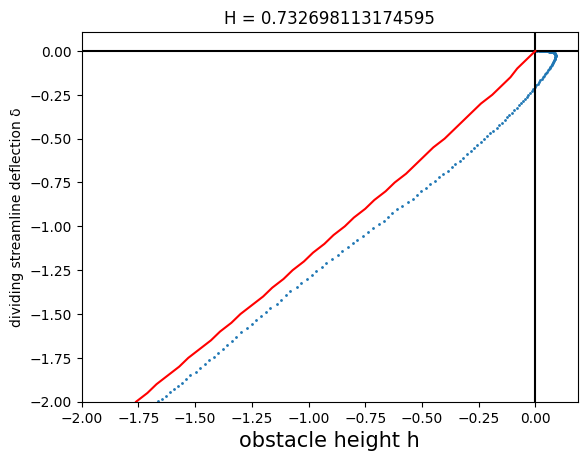

In [120]:
h, d, p_pert, cos_term, l, x_ind, x_parcel = t.get_h_and_displacement()

#three sig figs
smith_solution_1_3994_X = [-0.04, -0.08, -0.11, -0.15, -0.19, -0.24, -0.28, -0.32, -0.36, -0.40, 
                           -0.45, -0.49, -0.53, -0.57, -0.62, -0.66, -0.71, -0.75, -0.80, -0.84, 
                           -0.89, -0.93, -0.98, -1.02, -1.07, -1.11, -1.16, -1.20, -1.25, -1.30,
                          -1.34, -1.39, -1.43, -1.48, -1.53, -1.57, -1.62, -1.67, -1.71, -1.76]
smith_solution_1_3994_Y = np.linspace(0, -2, 41)

# deflection = (streamYsegments[163][:70] - streamYsegments[163][0]) * l
# h = (streamYsegments[182][:70] - streamYsegments[182][0]) * l
# plt.plot(h, deflection)
# plt.xlim([-2, 0.5])
# print(f'n(H_0) for time snaptshot streamfunctions is {(streamYsegments[163][0] - streamYsegments[182][0]) * l}')

# Pressure pert

In [29]:
jump_parcels = t.get_jump_parcels()

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_16272/3315041552.py:203: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_16272/3315041552.py:204: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_16272/3315041552.py:205: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

skips jump completey: 225 or 22.5%
v vel violation: 583 or 75.2258064516129%
monotonicity: 333 or 42.96774193548387%


In [31]:
len(jump_parcels) / len(t.x_data.columns)

0.185

In [124]:
top, bottom = t.z_data.iloc[0][jump_parcels].idxmax(), t.z_data.iloc[0][jump_parcels].idxmin()

findfont: Font family 'average' not found.
findfont: Font family 'average' not found.
findfont: Font family 'average' not found.
findfont: Font family 'average' not found.
findfont: Font family 'average' not found.
findfont: Font family 'average' not found.
findfont: Font family 'average' not found.


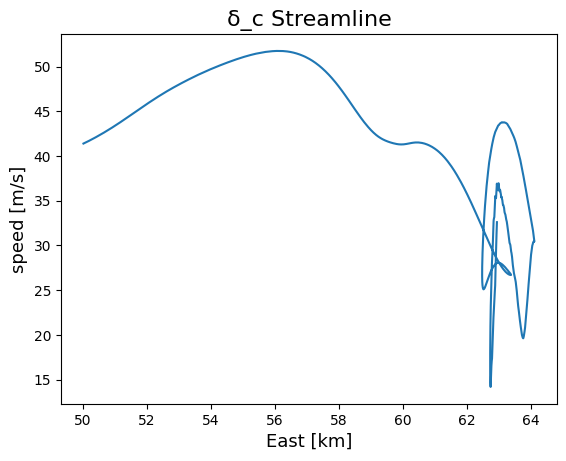

In [91]:
plt.plot(t.x_data[top] / 1000, t.speed_data[top])
plt.ylabel('speed [m/s]', fontsize=13)
plt.xlabel('East [km]', fontsize=13)
plt.title('\u03B4_c Streamline', fontsize=16)
plt.savefig('final_figures/dividing_streamline_speed.jpeg')

In [ ]:
# show the parcel paths of the dividing streamlines
t.plot_parcels([top, bottom], color_var='speed')

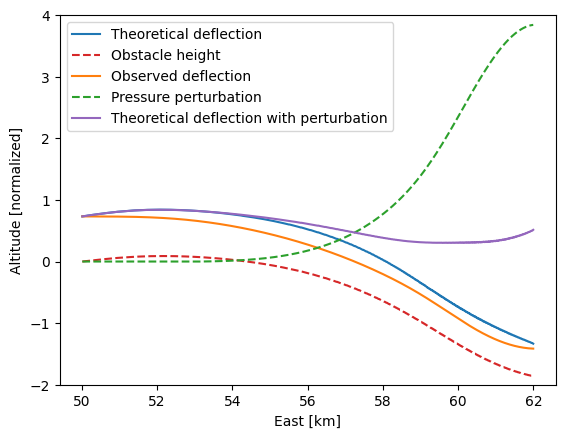

In [149]:
H = 0.732698
x = t.x_data.loc[d.index, top] / 1000
plt.plot(x, h / cos_term + H, label='Theoretical deflection', color='tab:blue')
plt.plot(x, h, '--', label='Obstacle height', color='tab:red')
plt.plot(x, d + H, label='Observed deflection', color='tab:orange')
plt.plot(x, p_pert, '--', label='Pressure perturbation', color='tab:green')
plt.plot(x, h / cos_term + p_pert * (np.sqrt(cos_term**(-2) - 1)) + H, label='Theoretical deflection with perturbation', color='tab:purple')
# plt.plot(cos_term, '--', label='cos_term')
plt.legend(loc='upper left')
plt.ylim([-2,4])
plt.xlabel('East [km]')
plt.ylabel('Altitude [normalized]')
plt.savefig('final_figures/deflections_on_x_p_pert.jpeg')

In [ ]:
# plot the parcel paths of all jump parcels
t.plot_parcels(t.get_jump_parcels())

# initial velocities

average divergence: 0.0432267526213322


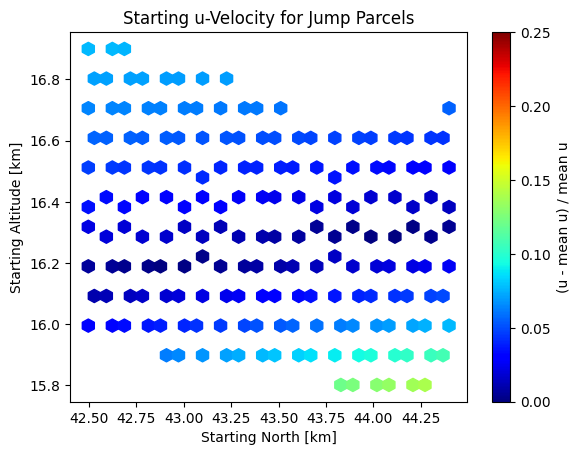

In [9]:
U_0_mean = t.u_data.loc[1, jump_parcels].mean()
plt.hexbin(
    t.y_data.loc[1,jump_parcels] / 1000,
    t.z_data.loc[1,jump_parcels] / 1000,
    C=((t.u_data.loc[1, jump_parcels] - U_0_mean).abs() / U_0_mean),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
plt.clim([0,0.25])
cb.set_label('(u - mean u) / mean u')
plt.title('Starting de-meaned u-Velocity for Jump Parcels')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
plt.savefig('final_figures/u_at_start.jpeg')
print(f'average divergence: {((t.u_data.loc[1, jump_parcels] - U_0_mean).abs() / U_0_mean).mean()}')

average value: 0.18131611690377808


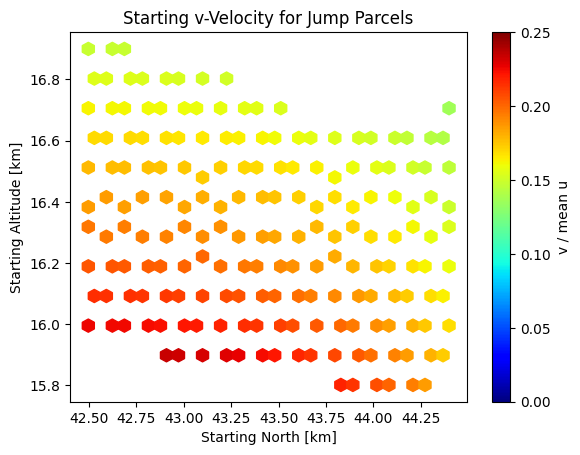

In [18]:
U_0_mean = t.u_data.loc[1, jump_parcels].mean()
plt.hexbin(
    t.y_data.loc[1,jump_parcels] / 1000,
    t.z_data.loc[1,jump_parcels] / 1000,
    C=(t.v_data.loc[1, jump_parcels].abs() / U_0_mean),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
plt.clim([0,0.25])
cb.set_label('v / mean u')
plt.title('Starting v-Velocity for Jump Parcels')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
plt.savefig('final_figures/v_at_start.jpeg')
print(f'average value: {(t.v_data.loc[1, jump_parcels].abs() / U_0_mean).mean()}')

average value: 0.042762434370468234


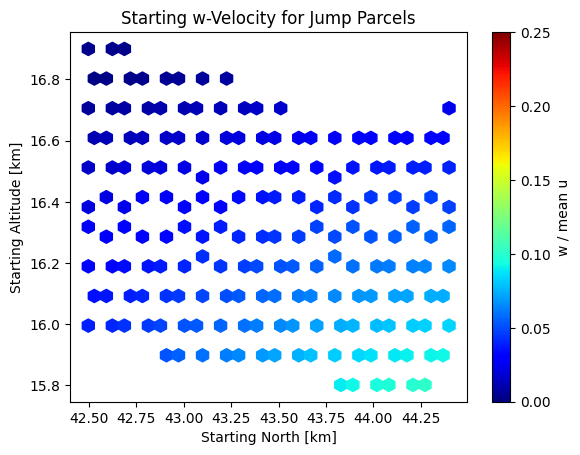

In [21]:
U_0_mean = t.u_data.loc[1, jump_parcels].mean()
plt.hexbin(
    t.y_data.loc[1,jump_parcels] / 1000,
    t.z_data.loc[1,jump_parcels] / 1000,
    C=(t.w_data.loc[1, jump_parcels].abs() / U_0_mean),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
plt.clim([0,0.25])
cb.set_label('w / mean u')
plt.title('Starting w-Velocity for Jump Parcels')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
plt.savefig('final_figures/w_at_start.jpeg')
print(f'average value: {(t.w_data.loc[1, jump_parcels].abs() / U_0_mean).mean()}')

average value: 0.1875040812270765


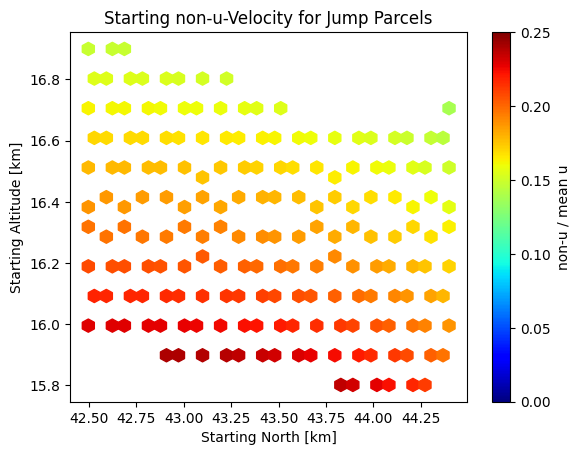

In [22]:
U_0_mean = t.u_data.loc[1, jump_parcels].mean()
plt.hexbin(
    t.y_data.loc[1,jump_parcels] / 1000,
    t.z_data.loc[1,jump_parcels] / 1000,
    C=(np.sqrt(t.v_data.loc[1, jump_parcels]**2 + t.w_data.loc[1, jump_parcels]**2) / U_0_mean),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
plt.clim([0,0.25])
cb.set_label('non-u / mean u')
plt.title('Starting non-u-Velocity for Jump Parcels')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
plt.savefig('final_figures/non_u_at_start.jpeg')
print(f'average value: {(np.sqrt(t.v_data.loc[1, jump_parcels]**2 + t.w_data.loc[1, jump_parcels]**2) / U_0_mean).mean()}')

# non-z lagrangian

Everything in this section is flawed because it doesn't differentiate between partial and full derivatives. Not commented thoroughly but can be if Morgan thinks there's salvageable stuff in here.
Understanding that flaw, what's attempted is to approximate the lagrangian term in the equation of state (which is simplified in Long's equation) to test the validity of that simplification.

In [6]:
def get_previous(parcel_idx, dataset, axis_dataset):
    dataset = dataset.astype(float)
    if dataset[parcel_idx] is None:
        return None
    lowers = dataset[axis_dataset < axis_dataset[parcel_idx] - 10]
    if lowers.empty:
        return None
    if pd.isnull(lowers.idxmax()):
        return None
    return lowers.idxmax()

def get_dist_back(parcel_idx, dataset, axis_dataset, max_dist):
    next_down = get_previous(parcel_idx, dataset, axis_dataset)
    if next_down is None:
        return None
    dist_down = axis_dataset[parcel_idx] - axis_dataset[next_down]
    if dist_down > max_dist:
        return None
    return dist_down

def differentiate(parcel_idx, dataset, axis_dataset, max_dist):
    next_down = get_previous(parcel_idx, dataset, axis_dataset)
    dist_down = get_dist_back(parcel_idx, dataset, axis_dataset, max_dist)
    if (
        (dataset[parcel_idx] is None) or
        (next_down is None) or
        (dataset[next_down] is None) or
        (dist_down is None)
    ):
        return None
    return (dataset[parcel_idx] - dataset[next_down]) / dist_down

def differentiate_time_step(time_step_data, time_step_axis_data, max_dist):
    derivative = pd.Series(index=time_step_data.index)
    for idx in time_step_data.index:
        derivative[idx] = differentiate(idx, time_step_data, time_step_axis_data, max_dist)
        
    return derivative

def differentiate_variable(variable_data, axis_data, max_dist=50):
    derivative = pd.DataFrame(index=variable_data.index, columns=variable_data.columns)
    for time_step in variable_data.index:
        derivative.loc[time_step] = differentiate_time_step(
            variable_data.loc[time_step],
            axis_data.loc[time_step],
            max_dist
        )
    derivative = derivative.loc[:, derivative.notnull().any()]
    return derivative

delta_x = differentiate_variable(t.jump_deflections.iloc[::10], t.x_data_jump.iloc[::10], 1000)
delta_xx = differentiate_variable(delta_x, t.x_data_jump.iloc[::10], 1000)

delta_y = differentiate_variable(t.jump_deflections.iloc[::10], t.y_data_jump.iloc[::10], 1000)
delta_yy = differentiate_variable(delta_y, t.y_data_jump.iloc[::10], 1000)

delta_z = differentiate_variable(t.jump_deflections.iloc[::10], t.z_data_jump.iloc[::10], 1000)
delta_zz = differentiate_variable(delta_z, t.z_data_jump.iloc[::10], 1000)

<Axes: xlabel='time_step'>

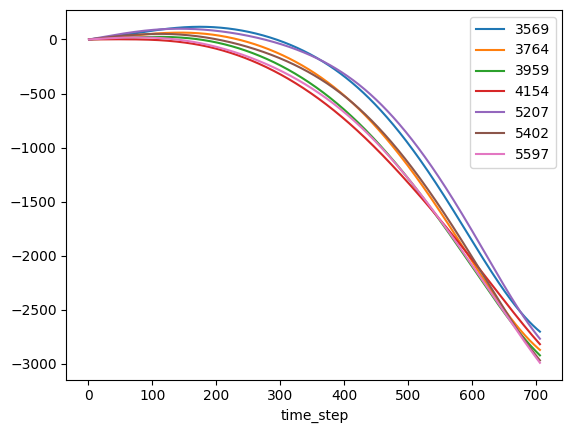

In [197]:
t.jump_deflections.iloc[:,::30].plot()

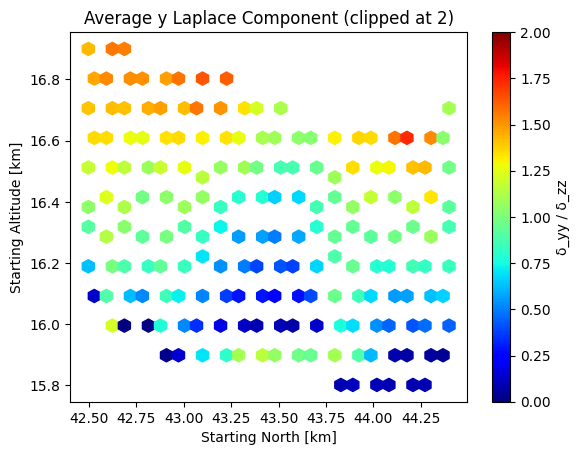

In [27]:
well_defined_cols = [i for i in delta_zz.columns if (i in delta_xx.columns and i in delta_yy.columns)]
plt.hexbin(
    t.y_data_jump[well_defined_cols].iloc[0] / 1000,
    t.z_data_jump[well_defined_cols].iloc[0] / 1000,
    C=(
        delta_yy[well_defined_cols].abs()
        / (delta_zz[well_defined_cols].abs() + 0.0001)
    ).clip(None, 2).mean(),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
plt.clim([0,2])
cb.set_label('\u03B4_yy / \u03B4_zz')
plt.title('Average y Laplace Component (clipped at 2)')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
plt.savefig('final_figures/y_laplace_at_start.jpeg')

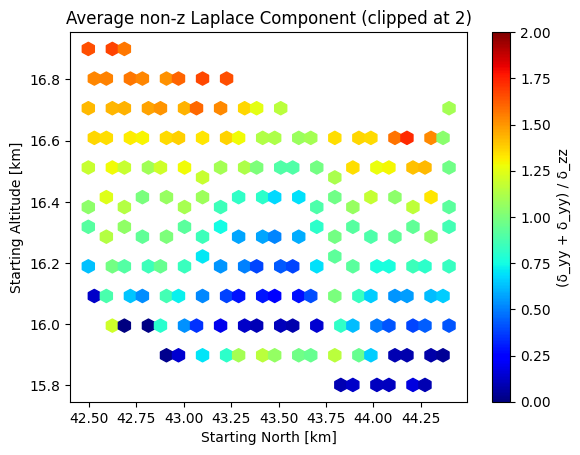

In [28]:
well_defined_cols = [i for i in delta_zz.columns if (i in delta_xx.columns and i in delta_yy.columns)]
plt.hexbin(
    t.y_data_jump[well_defined_cols].iloc[0] / 1000,
    t.z_data_jump[well_defined_cols].iloc[0] / 1000,
    C=(
        (delta_xx[well_defined_cols].abs()) + (delta_yy[well_defined_cols].abs())
        / (delta_zz[well_defined_cols].abs() + 0.0001)
    ).clip(None, 2).mean(),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
plt.clim([0,2])
cb.set_label('(\u03B4_yy + \u03B4_yy) / \u03B4_zz')
plt.title('Average non-z Laplace Component (clipped at 2)')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
plt.savefig('final_figures/non_z_laplace_at_start.jpeg')

In [17]:
df = px.data.gapminder()
template = 'plotly_white'

colmax = 1 # [1/m]
colmin = -1   # [1/m]
msize = 1

fig = go.Figure()

#env parcels
for parcel in delta_zz.columns:
    
    scatvar = delta_zz.loc[delta_zz[parcel].notnull(),parcel]
    fig.add_trace(go.Scatter3d(
        x=t.x_data_jump.loc[scatvar.index,parcel]/1000.,
        y=t.y_data_jump.loc[scatvar.index,parcel]/1000.,
        z=t.z_data_jump.loc[scatvar.index,parcel]/1000.,
        mode='markers',
        marker= dict(
            size=msize,
            color=scatvar,
            colorscale='Viridis',
            cmin=colmin,cmax=colmax,
#             colorbar=dict(title='Potential temperature [K]',thickness=15)
#                 colorbar=dict(title='Pressure [hPa]',thickness=15)
            colorbar=dict(title='delta_zz [1/m]',thickness=15)
        ),
        projection=dict(x=dict(show=True,opacity=0.1),z=dict(show=True,opacity=0.1))
    ))
    


fig.update_layout(#title = '3D Scatter plot of parcels that reach windspeed>%.f m/s'%thresh,
    template=template,
    showlegend=False,
    width=950,height=700,
    scene=dict(camera=dict(up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=0.06,y=-2.3,z=0.51)),
        xaxis=dict(title='East [km]'),yaxis=dict(title='North [km]'),zaxis=dict(title='Altitude [km]'),
        aspectmode='data'))

# fig.write_html('jump_windspeed.html')
# fig.write_image("fig2A.pdf")
iplot(fig)



In [23]:
df = px.data.gapminder()
template = 'plotly_white'

colmax = 2 # [1/m]
colmin = 0   # [1/m]
msize = 1

fig = go.Figure()

#env parcels
for parcel in delta_yy.columns:
    if parcel in delta_zz.columns and parcel in delta_xx.columns:
        non_zero_points = delta_zz[parcel][delta_zz[parcel].notnull() & delta_zz[parcel]!= 0].index
        scatvar = (
            delta_xx.loc[non_zero_points,parcel].abs() + delta_yy.loc[non_zero_points,parcel].abs() 
        ) / (delta_zz.loc[non_zero_points,parcel]).abs()
        fig.add_trace(go.Scatter3d(
            x=t.x_data_jump.loc[non_zero_points,parcel]/1000.,
            y=t.y_data_jump.loc[non_zero_points,parcel]/1000.,
            z=t.z_data_jump.loc[non_zero_points,parcel]/1000.,
            mode='markers',
            marker= dict(
                size=msize,
                color=scatvar,
                colorscale='Viridis',
                cmin=colmin,cmax=colmax,
    #             colorbar=dict(title='Potential temperature [K]',thickness=15)
    #                 colorbar=dict(title='Pressure [hPa]',thickness=15)
                colorbar=dict(title='(\u03B4_xx + \u03B4_yy) / \u03B4_zz',thickness=15)
            ),
            projection=dict(x=dict(show=True,opacity=0.1),z=dict(show=True,opacity=0.1))
        ))
        
fig.update_layout(#title = '3D Scatter plot of parcels that reach windspeed>%.f m/s'%thresh,
    template=template,
    title='Non-z Laplace omponent (clipped at 2)',
    showlegend=False,
    width=950,height=700,
    scene=dict(camera=dict(up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=0.06,y=-2.3,z=0.51)),
        xaxis=dict(title='East [km]'),yaxis=dict(title='North [km]'),zaxis=dict(title='Altitude [km]'),
        aspectmode='data'))

# fig.write_html('jump_windspeed.html')
# fig.write_image("fig2A.pdf")
iplot(fig)



# Scorer parameter correction

Similar note for this section as the one above, also uses the flawed differentiation from above. That said, the attempted calculation is to appriximate the gradients necessary to culculate the Scorer parameter everywhere in order to estimate how it's diverging from constant (as a possible source of error comparing against theory)

In [29]:
g = 9.81
u_0_env = t.u_data_jump.iloc[0].mean() # [m/s]

# background l
N_env = pd.Series()
l_env = pd.Series()
for time in t.z_data_jump.iloc[:-100].index:
    d_idx = t.z_data_jump.loc[time].idxmax()
    h_idx = t.z_data_jump.loc[time].idxmin()
#     med_idx = t.z_data_jump_jump.iloc[]
    H = t.z_data_jump.loc[time, d_idx] - t.z_data_jump.loc[time, h_idx] # [m]
    theta_env = t.theta_data_jump.loc[time].mean() # [K]
    theta_gradient_env = (t.theta_data_jump.loc[time, d_idx] - t.theta_data_jump.loc[time, h_idx]) / H # [K/m]
    N_env[time] = np.sqrt(g / theta_env * theta_gradient_env)
    l_env[time] = N_env[time] / u_0_env

# perturbation l

u_z = differentiate_variable(t.u_data_jump.iloc[::10], t.z_data_jump.iloc[::10], 1000)
u_zz = differentiate_variable(u_z, t.z_data_jump.iloc[::10], 1000)
theta_z = differentiate_variable(t.theta_data_jump.iloc[::10], t.z_data_jump.iloc[::10], 1000)

well_defined_cols = [i for i in u_zz.columns if (i in theta_z.columns)]

N = g / t.theta_data_jump.iloc[::10][well_defined_cols] * theta_z

l = N / t.u_data_jump.iloc[::10][well_defined_cols]

In [35]:
N

3569      3570      3571      3572      3573      3574   
time_step                                                               
1           0.00109  0.001036  0.000982  0.000928  0.000875  0.000824  \
11         0.001143  0.001082  0.001021  0.000961  0.000903  0.000846   
21         0.001198   0.00113  0.001062  0.000996  0.000932  0.000869   
31         0.001254  0.001177  0.001103   0.00103   0.00096  0.000892   
41         0.001306  0.001223  0.001141  0.001063  0.000987  0.000914   
...             ...       ...       ...       ...       ...       ...   
661             NaN       NaN       NaN  -0.00099 -0.000809 -0.000681   
671             NaN       NaN       NaN       NaN -0.000881 -0.000835   
681             NaN       NaN       NaN       NaN       NaN -0.001723   
691             NaN       NaN       NaN       NaN       NaN       NaN   
701             NaN       NaN       NaN       NaN       NaN       NaN   

               3630      3631      3632      3633  ...      5592      5593   
time_step                                          ...                       
1          0.000798  0.000748  0.000698  0.000647  ...  0.000197  0.000168  \
11         0.000812  0.000759  0.000706  0.000653  ...  0.000194  0.000166   
21         0.000827  0.000771  0.000715  0.000659  ...  0.000193  0.000164   
31         0.000841  0.000782  0.000723  0.000665  ...  0.000192  0.000163   
41         0.000855  0.000794  0.000732  0.000672  ...  0.000192  0.000163   
...             ...       ...       ...       ...  ...       ...       ...   
661        0.001225  0.001808  0.002309   0.00237  ...  0.000462  0.000401   
671        0.000997  0.001176  0.001651  0.002166  ...  0.000718  0.000641   
681        0.000826  0.000948  0.001043  0.001394  ...  0.001515  0.001417   
691       -0.001346  0.000752  0.000793  0.000892  ...  0.001947  0.002042   
701       -0.002191  -0.00214  0.000654  0.000702  ...  0.002243  0.002604   

               5594      5595      5596      5597      5598      5599   
time_step                                                               
1           0.00014  0.000113  0.000086  0.000061  0.000037  0.000014  \
11         0.000138  0.000111  0.000085   0.00006  0.000036  0.000014   
21         0.000136   0.00011  0.000084  0.000059  0.000036  0.000014   
31         0.000136  0.000109  0.000084  0.000059  0.000036  0.000014   
41         0.000135  0.000109  0.000083  0.000059  0.000036  0.000014   
...             ...       ...       ...       ...       ...       ...   
661        0.000341  0.000281  0.000221 -0.001093 -0.001868 -0.002272   
671        0.000538  0.000432  0.000323 -0.001028 -0.001649 -0.001952   
681        0.001173  0.000886  0.000635  0.000433 -0.001483 -0.001719   
691         0.00187  0.001569  0.001189  0.000827 -0.001076 -0.001482   
701        0.001199  0.001089  0.001898  0.001351  0.000893  0.000572   

               5655      5664  
time_step                      
1          0.000277  0.000048  
11         0.000275  0.000047  
21         0.000274  0.000046  
31         0.000273  0.000046  
41         0.000274  0.000046  
...             ...       ...  
661        0.000476  0.000058  
671        0.000559  0.000082  
681         0.00073  0.000133  
691        0.001158  0.000287  
701        0.001151  0.000549  

[71 rows x 185 columns]

In [53]:
N_env

1      0.025407
2      0.025421
3      0.025434
4      0.025447
5      0.025461
         ...   
602    0.026104
603    0.026058
604    0.026017
605    0.025985
606    0.025955
Length: 606, dtype: float64

In [52]:
(N.iloc[0] - N_env).isnull().sum()

791

Text(0, 0.5, 'Starting Altitude [km]')

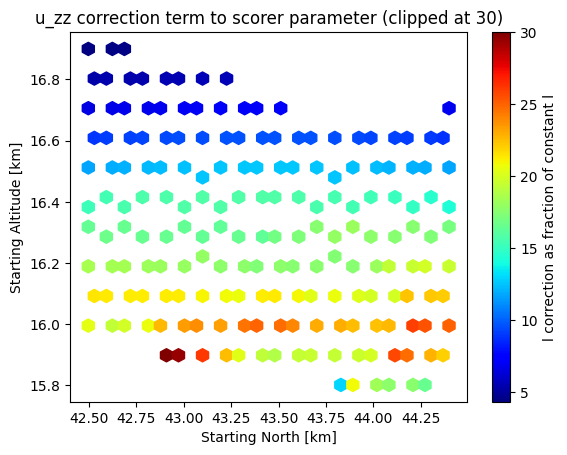

In [57]:
plt.hexbin(
    t.y_data_jump[u_zz.columns].iloc[0] / 1000,
    t.z_data_jump[u_zz.columns].iloc[0] / 1000,
    C=((u_zz / u_0_env) / (N_env.iloc[0] / u_0_env)**2).abs().clip(0, 30).mean(),
    gridsize=30,
    cmap=plt.cm.jet
)
cb = plt.colorbar()
# plt.clim([0,2])
cb.set_label('l correction as fraction of constant l')
plt.title('u_zz correction term to scorer parameter (clipped at 30)')
plt.xlabel('Starting North [km]')
plt.ylabel('Starting Altitude [km]')
# plt.savefig('final_figures/x_laplace_at_start.jpeg')

<Axes: >

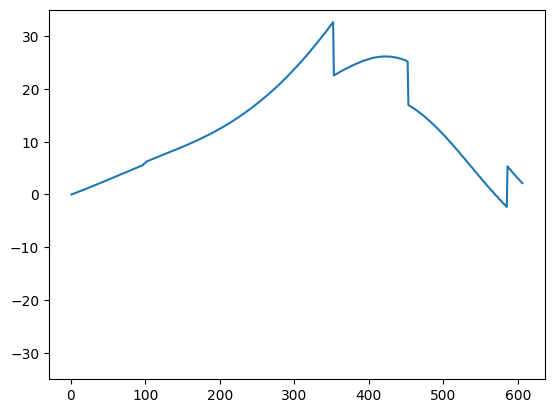

In [98]:
(100*(N_env- N_env.iloc[0])/N_env.iloc[0] ).plot(ylim=[-35,35])